<a href="https://colab.research.google.com/github/pinilDissanayaka/Skin-Diseases-Image-Classification/blob/main/Skin_Diseases_Using_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download haroonalam16/20-skin-diseases-dataset

 94% 303M/321M [00:02<00:00, 159MB/s]
100% 321M/321M [00:02<00:00, 141MB/s]


In [3]:
! unzip /content/20-skin-diseases-dataset.zip

Archive:  /content/20-skin-diseases-dataset.zip
  inflating: Dataset/test/Acne and Rosacea Photos/07PerioralDermEye.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07Rhinophyma1.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07RosaceaFulFAce.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07RosaceaMilia0120.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07RosaceaOK0828063.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07SteroidPerioral.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07SteroidPerioral1.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07VascularFace0120.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07rhnophymas0321051.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/07sebDerem1101051.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/08PerioralDerm1.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/ComedonesEars-1.jpg  
  inflating: Dataset/test/Acne and Rosacea Photos/Sebaceous-glands-

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKerasTF


import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
IMG_SIZE = [224, 224, 3]
basedir = '/content/Dataset'

In [7]:
traindir = basedir + '/' + 'train'
testdir = basedir + '/' + 'test'

In [8]:
print(f"Traing set has {len(os.listdir(traindir))} folders")
print(f"Testing set has {len(os.listdir(testdir))} folders")

outputsize = len(os.listdir(traindir))

Traing set has 19 folders
Testing set has 20 folders


In [9]:
import shutil

shutil.rmtree('/content/Dataset/test/Bullous Disease Photos')

In [12]:
denseNet = DenseNet201(include_top= False, weights = 'imagenet', input_shape = IMG_SIZE)

In [32]:
for layer in denseNet.layers:
  layer.trainable = True

In [14]:
x = Flatten()(denseNet.output)

x = Dense(units = 128, activation = 'relu')(x)
x = Dense(units = outputsize, activation = 'softmax')(x)

In [16]:
model = Model(inputs = [denseNet.input], outputs = [x])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [18]:
earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=1)

In [19]:
traindatagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.9,
    horizontal_flip=True)

testdatagen = ImageDataGenerator(
    rescale=1./255)

In [20]:
traindf = traindatagen.flow_from_directory(
        traindir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

testdf = traindatagen.flow_from_directory(
        testdir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 2609 images belonging to 19 classes.
Found 895 images belonging to 19 classes.


In [24]:
outClasses = {v : k for k, v in traindf.class_indices.items()}

outClasses

{0: 'Acne and Rosacea Photos',
 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 2: 'Atopic Dermatitis Photos',
 3: 'Cellulitis Impetigo and other Bacterial Infections',
 4: 'Eczema Photos',
 5: 'Exanthems and Drug Eruptions',
 6: 'Herpes HPV and other STDs Photos',
 7: 'Light Diseases and Disorders of Pigmentation',
 8: 'Lupus and other Connective Tissue diseases',
 9: 'Melanoma Skin Cancer Nevi and Moles',
 10: 'Poison Ivy Photos and other Contact Dermatitis',
 11: 'Psoriasis pictures Lichen Planus and related diseases',
 12: 'Seborrheic Keratoses and other Benign Tumors',
 13: 'Systemic Disease',
 14: 'Tinea Ringworm Candidiasis and other Fungal Infections',
 15: 'Urticaria Hives',
 16: 'Vascular Tumors',
 17: 'Vasculitis Photos',
 18: 'Warts Molluscum and other Viral Infections'}

In [26]:
stepsPertrainingEpoch = traindf.n // traindf.batch_size
stepsPerTestingEpoch = testdf.n // testdf.batch_size


print(f"Every training epoch has {stepsPertrainingEpoch} steps.")
print(f"Every testing epoch has {stepsPerTestingEpoch} steps.")

Every training epoch has 81 steps.
Every testing epoch has 27 steps.


In [30]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("/model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

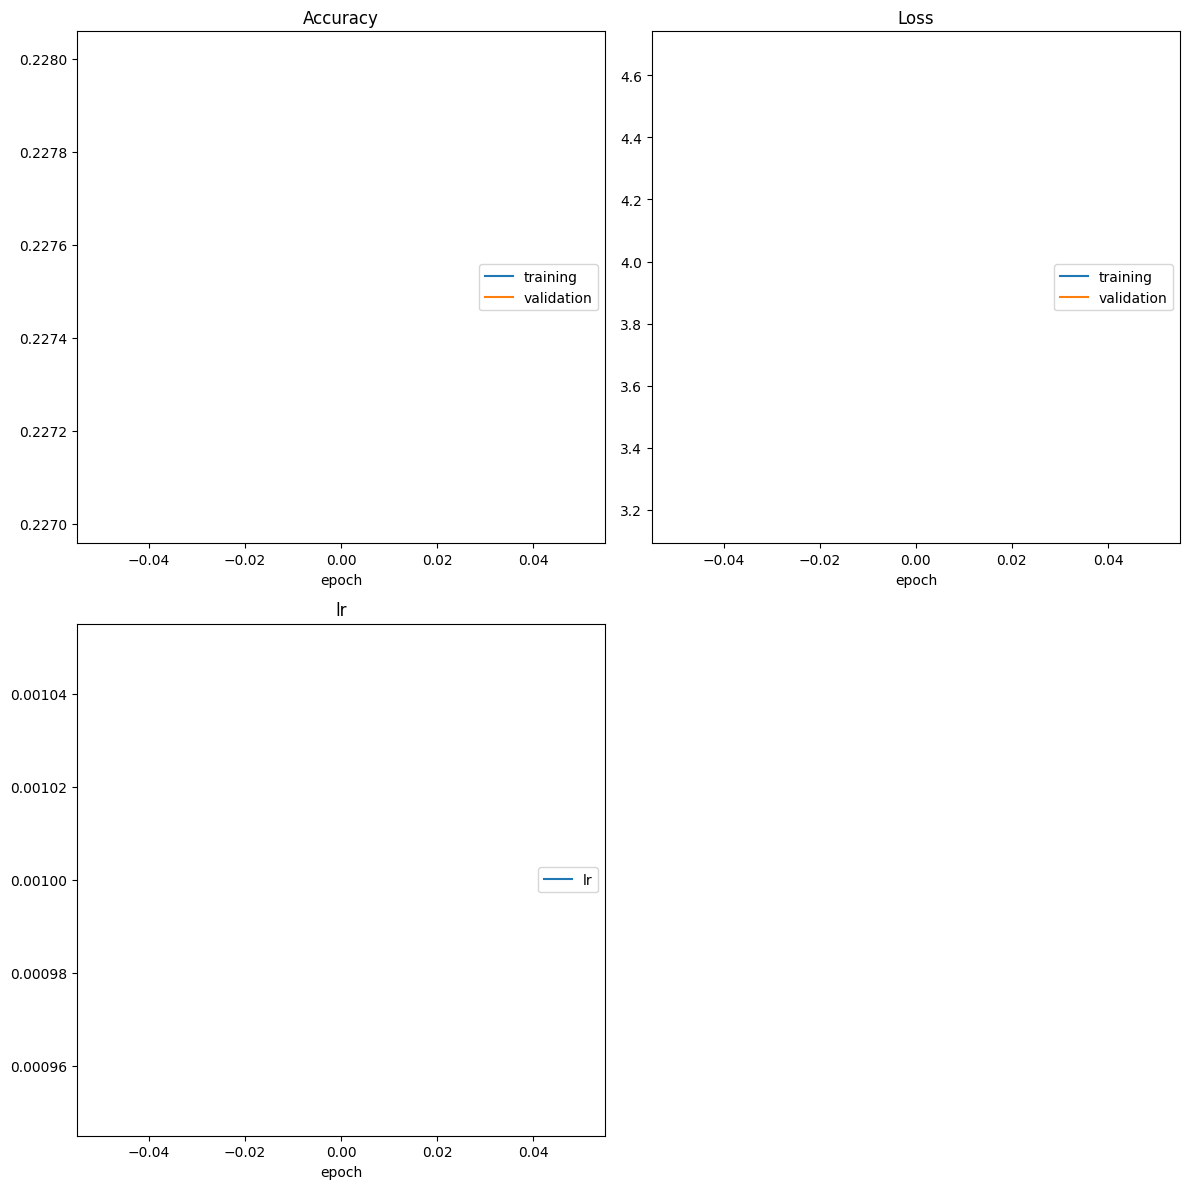

Accuracy
	training         	 (min:    0.227, max:    0.227, cur:    0.227)
	validation       	 (min:    0.228, max:    0.228, cur:    0.228)
Loss
	training         	 (min:    4.667, max:    4.667, cur:    4.667)
	validation       	 (min:    3.167, max:    3.167, cur:    3.167)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
81/81 [==============================] - 88s 846ms/step - loss: 4.6669 - acc: 0.2270 - val_loss: 3.1671 - val_acc: 0.2280 - lr: 0.0010
Epoch 2/5
29/81 [=========>....................] - ETA: 27s - loss: 2.6357 - acc: 0.2848

KeyboardInterrupt: 

In [31]:
model_history = model.fit_generator(
    traindf,
    epochs = 5,
    verbose = 1,
    validation_data = testdf,
    steps_per_epoch = stepsPertrainingEpoch,
    validation_steps = stepsPerTestingEpoch,
    callbacks = callBacks
)